PROJECT_ROOT: c:\Users\asus\OneDrive\EV-projects\evcs-projects
methods loaded from: c:\Users\asus\OneDrive\EV-projects\evcs-projects\src\evcs\methods.py
DR loaded from: c:\Users\asus\OneDrive\EV-projects\evcs-projects\scripts\destruction_reconstruction.py
N=150 seed=11 T=4 policy=closest_only P_T=[2, 2, 1, 1] Q=1.0 D=1.5
Loaded: c:\Users\asus\OneDrive\EV-projects\evcs-projects\data\instances\inst_N150_seed11_T4_trend_up.json
meta.T: 4
demand_IT: 4 periods | each has 150 demands
score_exact : 16.999999999999996
score_greedy: 17.0
termination: TerminationCondition.optimal
proven_opt : True


,method,covered_demand_total,termination,proven_optimal,gap,time_sec
0,Exact (time-limited),17.0,optimal,True,None,1.695841
1,Greedy schedule + greedy assign,17.0,heuristic,None,None,NaN


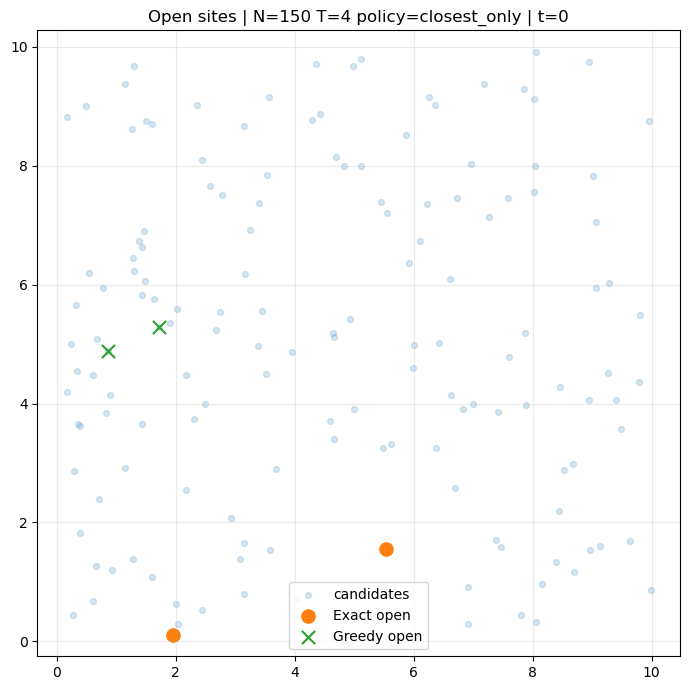

,iteration,score,best,time,k_remove,destroy_mode
190,191,17.0,17.0,69.714650,1,random
191,192,17.0,17.0,70.037751,1,random
192,193,17.0,17.0,70.355286,1,random
193,194,17.0,17.0,70.684542,1,random
194,195,17.0,17.0,71.001494,1,random
195,196,17.0,17.0,71.319487,1,random
196,197,17.0,17.0,71.668704,1,random
197,198,17.0,17.0,71.994068,1,random
198,199,17.0,17.0,72.328467,1,random
199,200,17.0,17.0,73.104897,1,random


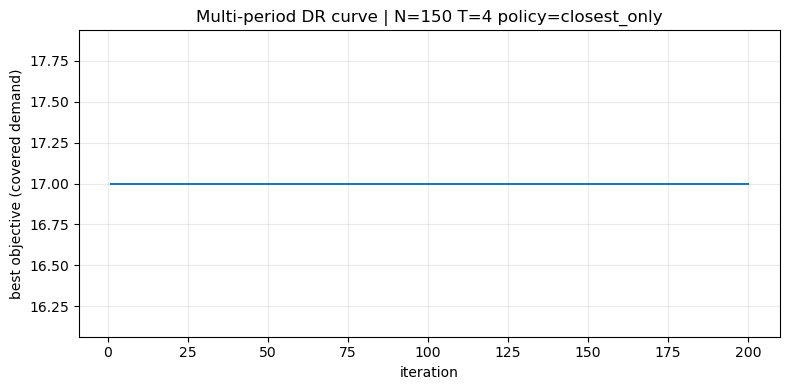

In [ ]:
# =========================
# CELL 1) Imports + paths
# =========================
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

PROJECT_ROOT = Path(r"c:\Users\asus\OneDrive\EV-projects\evcs-projects")
print("PROJECT_ROOT:", PROJECT_ROOT)

# Put src first
sys.path.insert(0, str(PROJECT_ROOT / "src"))
sys.path.insert(0, str(PROJECT_ROOT / "scripts"))
sys.path.insert(0, str(PROJECT_ROOT))

# Force reload to avoid stale code
import evcs.methods as M
import destruction_reconstruction as DR
importlib.reload(M)
importlib.reload(DR)

print("methods loaded from:", M.__file__)
print("DR loaded from:", DR.__file__)

from scripts.randomInstance import generate_instance, save_instance, load_instance
from destruction_reconstruction import run_one_policy_multi


# =========================
# CELL 2) Settings
# =========================
N = 150
seed = 11

T = 4
P_T = [2, 2, 1, 1]

policy = "closest_only"  # closest_only | closest_priority | system_optimum | uniform

Q = 1.0
D = 1.5
max_chargers_per_site = 5

exact_time_limit = 120
exact_mip_gap = 0.10

demand_pattern = "trend_up"
period_noise = 0.05

print(f"N={N} seed={seed} T={T} policy={policy} P_T={P_T} Q={Q} D={D}")


# =========================
# CELL 3) Load or generate instance
# =========================
inst_dir = PROJECT_ROOT / "data" / "instances"
inst_dir.mkdir(parents=True, exist_ok=True)
inst_path = inst_dir / f"inst_N{N}_seed{seed}_T{T}_{demand_pattern}.json"

if inst_path.exists():
    inst = load_instance(str(inst_path))
    print("Loaded:", inst_path)
else:
    inst = generate_instance(
        N=N, seed=seed,
        T=T,
        demand_pattern=demand_pattern,
        period_noise=period_noise
    )
    save_instance(inst, str(inst_path))
    print("Generated & saved:", inst_path)

print("meta.T:", inst.get("meta", {}).get("T"))
print("demand_IT:", len(inst["demand_IT"]), "periods | each has", len(inst["demand_IT"][0]), "demands")


# =========================
# CELL 4) Run
# =========================
out = run_one_policy_multi(
    inst=inst,
    policy=policy,
    P_T=P_T,
    Q=Q, D=D, T=T,
    exact_time_limit=exact_time_limit,
    exact_mip_gap=exact_mip_gap,
    max_chargers_per_site=max_chargers_per_site,
    cumulative_install=True,
    seed=seed,
    verbose=False
)

print("score_exact :", out["score_exact"])
print("score_greedy:", out["score_greedy"])
print("termination:", out["exact_termination"])
print("proven_opt :", out["proven_optimal_exact"])


# =========================
# CELL 5) Pretty table
# =========================
import pandas as pd
from IPython.display import display

def pretty_term(s):
    if s is None:
        return None
    return str(s).split(".")[-1]

cmp = pd.DataFrame([
    {
        "method": "Exact (time-limited)",
        "covered_demand_total": out["score_exact"],
        "termination": pretty_term(out["exact_termination"]),
        "proven_optimal": out["proven_optimal_exact"],
        "gap": out["exact_gap"],
        "time_sec": out["time_exact"],
    },
    {
        "method": "Greedy schedule + greedy assign",
        "covered_demand_total": out["score_greedy"],
        "termination": "heuristic",
        "proven_optimal": None,
        "gap": None,
        "time_sec": None,
    },
])

display(cmp)



# =========================
# CELL 6) Plot: open sites at t=0 (exact vs greedy)
# =========================
m_exact = out["m_exact"]
m_best = out["m_best"]
coords_J = np.asarray(inst["coords_J"])

def open_sites_t(m, t):
    if m is None:
        return []
    if hasattr(m, "z"):
        return [int(j) for j in m.J if (m.z[j, t].value or 0.0) > 0.5]
    return [int(j) for j in m.J if (m.x[j, t].value or 0.0) > 0.5]

t_view = 0
open_e = open_sites_t(m_exact, t_view)
open_g = open_sites_t(m_best,  t_view)

plt.figure(figsize=(7,7))
plt.scatter(coords_J[:,0], coords_J[:,1], s=18, alpha=0.18, label="candidates")

if open_e:
    pts = coords_J[open_e]
    plt.scatter(pts[:,0], pts[:,1], s=90, marker="o", label="Exact open")

if open_g:
    pts = coords_J[open_g]
    plt.scatter(pts[:,0], pts[:,1], s=90, marker="x", label="Greedy open")

plt.title(f"Open sites | N={N} T={T} policy={policy} | t={t_view}")
plt.axis("equal")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

from destruction_reconstruction import run_DR_multi

out_dr = run_DR_multi(
    inst=inst,
    policy=policy,
    P_T=P_T,
    Q=Q, D=D, T=T,
    max_iter=200,
    dr_time_limit=120,
    frac_remove=0.20,
    destroy_mode="random",
    max_chargers_per_site=5,
    cumulative_install=True,
    seed=seed,
)

df = out_dr["DR_log"]
display(df.tail(10))

plt.figure(figsize=(8,4))
plt.plot(df["iteration"], df["best"])
plt.xlabel("iteration")
plt.ylabel("best objective (covered demand)")
plt.title(f"Multi-period DR curve | N={N} T={T} policy={policy}")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()
